In [1]:
import numpy as np
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from imgaug import augmenters as iaa
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label
from random import randint
import os
import glob

In [2]:
def read_img(img_path):
    # .png file reads in normalized value between 0-1.  Convert it to 255 scale like JPG.
    if '.png' in img_path:
        return (mpimg.imread(img_path)[:, :, :3] * 255).astype('uint8')
    else:
        return mpimg.imread(img_path)


def binary_output(img, thresh=(0, 255)):
    temp = np.zeros_like(img)
    temp[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return temp


def change_color(img, color = 'RGB', selection = 'all'):
    # Convert ColorSpace
    if color == 'RGB':
        pass
    else:
        color_dict = {'HLS': 53, 'GRAY': 7, 'XYZ': 33, 'HSV': 41,
                      'LAB': 45, 'LUV': 51, 'YUV': 83, 'YCrCb': 37}
        img = cv2.cvtColor(img, color_dict[color])
        
    # Select channel
    if selection == 'all':
        return img
    else:
        img = img[:, :, selection]
        return img
        
        
def preprocess(img_path, color = 'RGB', selection = 'all', size = (64, 64)):

    if isinstance(img_path, list):
        images=[]
        for img in img_path:
            img = change_color(read_img(img), color = color, selection = selection)
            img = cv2.resize(img, size)
            images.append(img)
        return images


    img = change_color(read_img(img_path), color = color, selection = selection)
    img = cv2.resize(img, size)

    return img


def augmentation(imgs, size=1000):

    if isinstance(imgs, list):
        
        first_img = imgs[0]
        
        if len(first_img.shape) == 2:
            first_img = first_img[..., np.newaxis]
            print("Augmenting single-channel Image...")
        else:
            print("Augmenting multi-channel Image...")

        seq = iaa.Sequential([iaa.Crop(px=(0, 16)), 
                              iaa.Fliplr(0.5),
                              iaa.GaussianBlur(sigma=(0, 3.0))
                             ])

        images_aug = np.empty([size, first_img.shape[0], first_img.shape[1],
                               first_img.shape[2]]).astype('uint8')
        for i in range(size):
            img_index = randint(0, len(imgs)-1)
            output = seq.augment_image(imgs[img_index])
            images_aug[i] = output
        return images_aug
    
#         for k, img in enumerate(imgs):
#             for i in range(size):

#                 output = seq.augment_image(img)
#                 images_aug[k*1000 + i] = output
#         return images_aug
    else:
        first_img = img
        
        if len(first_img.shape) == 2:
            first_img = first_img[..., np.newaxis]
            print("Augmenting single-channel Image...")
        else:
            print("Augmenting multi-channel Image...")

        seq = iaa.Sequential([iaa.Crop(px=(0, 16)), 
                              iaa.Fliplr(0.5),
                              iaa.GaussianBlur(sigma=(0, 3.0))
                             ])

        images_aug = np.empty([len(imgs)*size, first_img.shape[0], first_img.shape[1],
                               first_img.shape[2]]).astype('uint8')
        for i in range(size):

            output = seq.augment_image(img)
            images_aug[i] = output        

        return images_aug


def plot_images(imgs):

    plt.figure(figsize=(20,10))

    for i in range(20):
        if imgs[i].shape[2] == 1:
            img_draw = np.squeeze(imgs[i], axis=(2,))
            plt.subplot(4, 5, i+1)
            plt.imshow(img_draw, cmap='gray')
        else:
            img_draw = imgs[i] 
            plt.subplot(4, 5, i+1)
            plt.imshow(img_draw)

    plt.show()


def visualize(img_path, color = 'RGB', selection = 'all'):
    plot_images(augmentation(preprocess(img_path, color = color, selection = selection)))

### Various Feature Extracting Functions

In [3]:
def hog_features(img, orient=9, pix_per_cell=8, cell_per_block=3, vis = False, feature_vec = True):
    
    if len(img.shape) == 3:
        img = np.squeeze(img, axis=(2,))
        
    if vis == False:
        features = hog(img, 
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis,
                       block_norm='L2-Hys',
                       feature_vector=feature_vec)
        return features
    else:
        features, hog_img = hog(img, orientations=orient,
                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block),
                                 transform_sqrt=True,
                                 visualise=vis,
                                 block_norm='L2-Hys',
                                 feature_vector=feature_vec)
        return features, hog_img

    
def spatial_features(img, size=(32, 32)):
    
    features = cv2.resize(img, size).ravel()
    
    return features

def hist_features(img, nbins=32, bins_range=(0, 256)):
    
    chan_1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    chan_2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    chan_3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    features = np.concatenate((chan_1[0], chan_2[0], chan_3[0]))
    
    return features

### Combined Feature Extraction

In [4]:
def feature_extraction(img, 
                       color='RGB', 
                       spatial_size=(32,32), 
                       hist_bins=32,
                       orient=9, 
                       pix_per_cell=8, 
                       cell_per_block=2, 
                       spatial_feat=True, 
                       hist_feat=True, 
                       hog_feat=True):
    
    img_features = []
    
    feature_img = change_color(img, color=color)
    
    if spatial_feat == True:
        s_features = spatial_features(feature_img, size=spatial_size)
        img_features.append(s_features)
    
    if hist_feat == True:
        h_features = hist_features(feature_img, nbins=hist_bins)
        img_features.append(h_features)
        
    if hog_feat == True:
        hg_features = hog_features(change_color(feature_img, color='GRAY'), orient, pix_per_cell,
                                   cell_per_block, vis=False, feature_vec=True)
        img_features.append(hg_features)
        
    return np.concatenate(img_features)

### Loading Data

In [5]:
hand_list = glob.glob('./images/positive/*')
print(len(hand_list))
rand_list = glob.glob('./images/negative/*')
print(len(rand_list))

14
14


In [6]:
hand_imgs = augmentation(preprocess(hand_list), size=5000)
rand_imgs = augmentation(preprocess(rand_list), size=5000)

Augmenting multi-channel Image...
Augmenting multi-channel Image...


### Visualizing Data

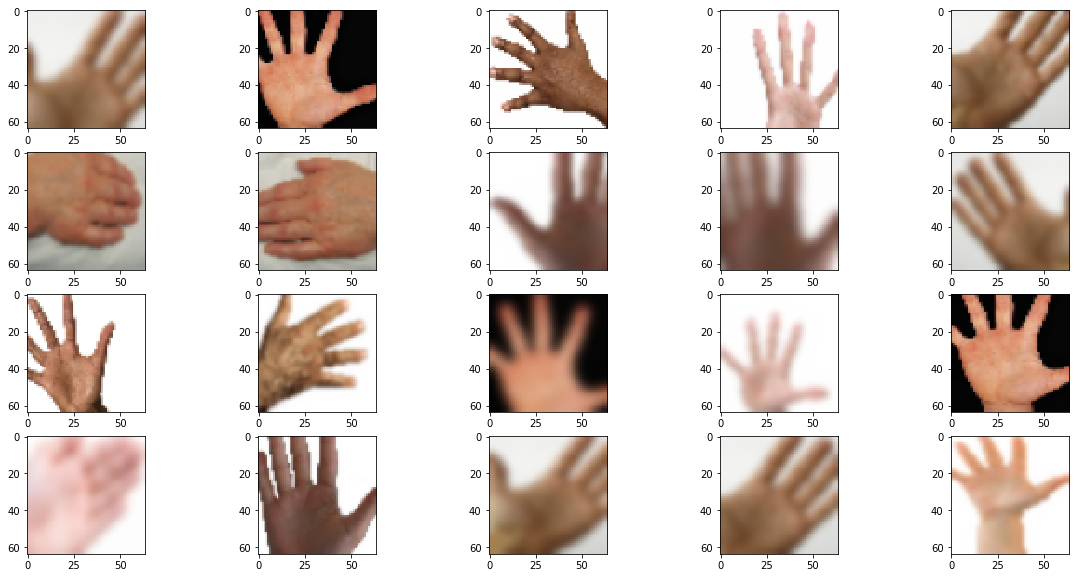

In [7]:
plot_images(hand_imgs)

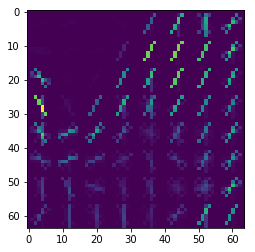

In [8]:
sample_ar, sample_img = hog_features(change_color(hand_imgs[0], color='GRAY'), vis=True)
plt.imshow(sample_img)
plt.show()

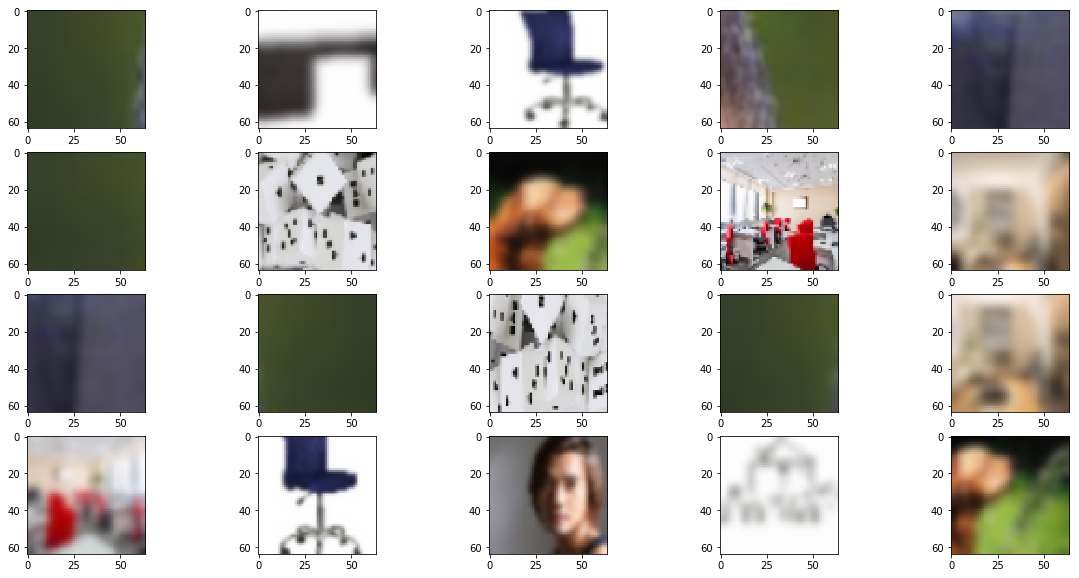

In [9]:
plot_images(rand_imgs)

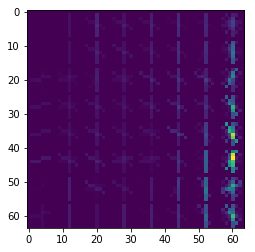

In [10]:
sample_ar, sample_img = hog_features(change_color(rand_imgs[0], color='GRAY'), vis=True)
plt.imshow(sample_img)
plt.show()

### Feature Extraction

In [ ]:
# constants
color_space = 'RGB'
spatial_feat=True
hist_feat=True
hog_feat=True

In [ ]:
hand_features = []

for img in hand_imgs:
    hand_features.append(feature_extraction(img, 
                                            color = color_space, 
                                            spatial_feat=spatial_feat, 
                                            hist_feat=hist_feat, 
                                            hog_feat=hog_feat))

In [ ]:
rand_features = []

for img in rand_imgs:
    rand_features.append(feature_extraction(img, 
                                            color = color_space, 
                                            spatial_feat=spatial_feat, 
                                            hist_feat=hist_feat, 
                                            hog_feat=hog_feat))

### Train Classifier

In [ ]:
X = np.vstack((hand_features, rand_features)).astype(np.float64)
print(len(X))
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
print(np.min(scaled_X))
print(np.max(scaled_X))
y = np.hstack((np.ones(len(hand_features)), np.zeros(len(rand_features))))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=7)

In [ ]:
model = LinearSVC()
model.fit(X_train, y_train)

In [ ]:
t = time.time()
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(model.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

### Sliding Windows

In [ ]:
def slide_window(img, 
                 x_start_stop=[None, None], 
                 y_start_stop=[None, None],
                 xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bbox_list

def final_heat(img, hot_windows):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

def search_windows(img, 
                   windows, 
                   clf, 
                   scaler, 
                   color_space='RGB',
                   spatial_size=(32, 32), 
                   hist_bins=32, 
                   hist_range=(0, 256), 
                   orient=9, 
                   pix_per_cell=8, 
                   cell_per_block=2,
                   spatial_feat=True,
                   hist_feat=True,
                   hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = feature_extraction(test_img, 
                                      spatial_size=spatial_size, 
                                      hist_bins=hist_bins, 
                                      orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat, 
                                      hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [ ]:
search_img = mpimg.imread('./images/control/obama.jpg')

In [ ]:
draw_image = np.copy(search_img)
y_start_stop = [None, None] # Min and max in y to search in slide_window()

spatial_size = (32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2

windows = slide_window(search_img, 
                       x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, 
                       xy_window=(32, 32), 
                       xy_overlap=(0.7, 0.7))

hot_windows = search_windows(search_img, 
                             windows, 
                             model, 
                             X_scaler, 
                             color_space=color_space, 
                             spatial_size=spatial_size, 
                             hist_bins=hist_bins, 
                             orient=orient, 
                             pix_per_cell=pix_per_cell, 
                             cell_per_block=cell_per_block, 
                             spatial_feat=spatial_feat, 
                             hist_feat=hist_feat, 
                             hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

display_windows = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('original')
plt.imshow(search_img)
plt.subplot(122)
plt.title('window search')
plt.imshow(display_windows)
plt.show()

heat = np.zeros_like(search_img[:,:,0]).astype(np.float)
heat = add_heat(heat, hot_windows)
heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)

draw_img, draw_box = draw_labeled_bboxes(np.copy(search_img), labels)

print(draw_box)

# draw_img = final_heat(image, hot_windows)
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.title('classified')
plt.imshow(window_img)
plt.subplot(122)
plt.title('heat mapped')
plt.imshow(draw_img)
plt.show()